In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time
from scipy.special import kv
from scipy.integrate import quad

from pulsars import Pulsars, c, e_charge, e_mass, h
import speiser_fun as sf 
import speiser_fun_cyl as sfc
import speiser_integ as si
import speiser_plots as sp
import speiser_model as sm
import speiser_spec as ss

In [2]:
k = 1000.
name = 'crab'
pulsar = Pulsars(k)[name]

gamma1 = 1.
B_0 = pulsar['Blc']
omegaB = (e_charge*B_0/(e_mass*c))    #γυροσυχνότητα
Rlc = pulsar['rlc']*omegaB/c
Delta = pulsar['rlc']/k*omegaB/c

gamma0 = np.linspace(10., 3000., 15)    #αρχικός παράγοντας Lorentz
# gamma0 = np.array([200., 200., 200., 1.])
N = gamma0**(-1)
delta = 100.    #πάχος του φύλλου ρεύματος, αδιάστατο, σε μονάδες [c/ωΒ]

In [5]:
start_time = time.time()

T = 60.
N = 1*10**4

t = np.linspace(0.0, T*Delta, N)

(r, ur, phi, uphi, z_cyl, uz_cyl), dic_cyl = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, t, sm.speiser_cyl, coord = 'cyl')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cylindrical with losses = {:1.2E} s'.format(elapsed))

10.0
223.57142857142858


/home/petros/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


437.14285714285717
650.7142857142858
864.2857142857143
1077.857142857143
1291.4285714285716
1505.0
1718.5714285714287
1932.1428571428573
2145.714285714286
2359.285714285714
2572.857142857143
2786.4285714285716
total runtime for cylindrical with losses = 1.32E+03 s


In [6]:
start_time = time.time()

T = 60.
N = 1*10**4
t1 = np.linspace(0.0, T*Delta, N)

(r1, ur1, phi1, uphi1, z_cyl1, uz_cyl1), dic_cyl1 = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, t1, sm.speiser_cyl_noloss, coord = 'cyl')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cylindrical without losses = {:1.2E} s'.format(elapsed))

10.0
223.57142857142858
437.14285714285717
650.7142857142858
864.2857142857143
1077.857142857143
1291.4285714285716
1505.0
1718.5714285714287
1932.1428571428573
2145.714285714286
2359.285714285714
2572.857142857143
2786.4285714285716
total runtime for cylindrical without losses = 2.63E+02 s


In [7]:
start_time = time.time()

T = 60.
N = 1*10**4
t2 = np.linspace(0.0, T*Delta, N)

(r2, ur2, phi2, uphi2, z_cyl2, uz_cyl2), dic_cyl2 = si.oloklirosi(gamma0, Rlc, Delta, delta, B_0, t2, sm.speiser_cyl_Rlc, coord = 'cyl')

# #λήξη χρονομέτρησης
elapsed = time.time() - start_time

print('total runtime for cylindrical with explicit losses = {:1.2E} s'.format(elapsed))

10.0
223.57142857142858
437.14285714285717
650.7142857142858
864.2857142857143
1077.857142857143
1291.4285714285716
1505.0
1718.5714285714287
1932.1428571428573
2145.714285714286
2359.285714285714
2572.857142857143
2786.4285714285716
total runtime for cylindrical with explicit losses = 6.50E+02 s


<IPython.core.display.Javascript object>


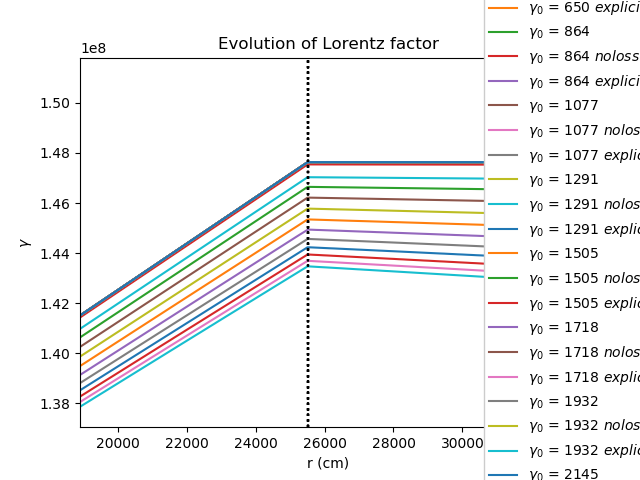

<IPython.core.display.Javascript object>


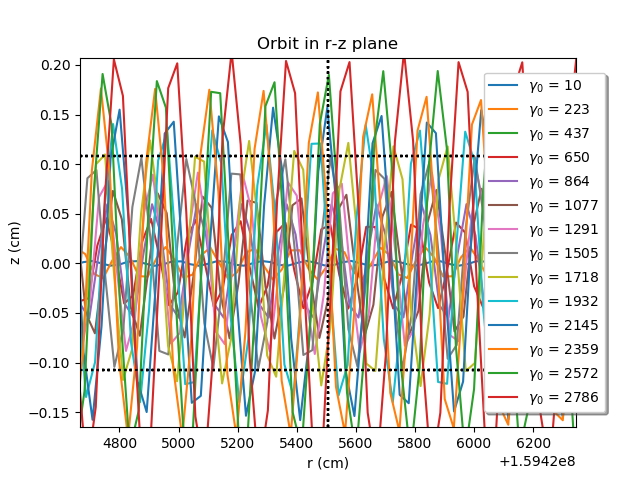

<IPython.core.display.Javascript object>


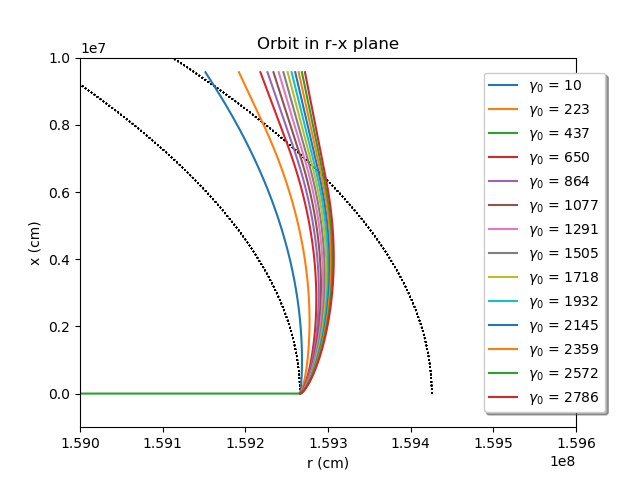

In [8]:
%matplotlib notebook

fig1, ax1 = plt.subplots()
for i in range(0, len(gamma0)-1):
    ax1.plot(r[i]*c/omegaB, sf.gamma(ur[i], uphi[i], uz_cyl[i]), label = '$\gamma_0$ = {}'.format(int(gamma0[i])))
    ax1.plot(r1[i]*c/omegaB, sf.gamma(ur1[i], uphi1[i], uz_cyl1[i]), label = '$\gamma_0$ = {} $no loss$'.format(int(gamma0[i])))
    ax1.plot(r2[i]*c/omegaB, sf.gamma(ur2[i], uphi2[i], uz_cyl2[i]), label = '$\gamma_0$ = {} $explicit loss$'.format(int(gamma0[i])))

    ax1.set(xlabel = 'r (cm)', ylabel = '$\gamma$', title = 'Evolution of Lorentz factor')
    ax1.axvline(x = Rlc*c/omegaB, linestyle = ':', color = 'k')
    ax1.axvline(x = (Rlc - Delta)*c/omegaB, linestyle = ':', color = 'k')
    ax1.legend(loc='center left', ncol=1, fancybox=True, shadow=True, bbox_to_anchor=(0.8, 0.5))
#     fig1.savefig('γ(r)')

fig2, ax2 = plt.subplots()    
for i in range(0, len(gamma0) - 1):
    ax2.plot(r[i]*c/omegaB, z_cyl[i]*c/omegaB, label = '$\gamma_0$ = {}'.format(int(gamma0[i])))
    ax2.axhline(y = delta*c/omegaB, linestyle = ':', color = 'k')
    ax2.axhline(y = -delta*c/omegaB, linestyle = ':', color = 'k')
    ax2.axvline(x = Rlc*c/omegaB, linestyle = ':', color = 'k')
    ax2.axvline(x = (Rlc - Delta)*c/omegaB, linestyle = ':', color = 'k')
    ax2.set(xlabel = 'r (cm)', ylabel = 'z (cm)', title = 'Orbit in r-z plane')
    ax2.legend(loc='center left', ncol=1, fancybox=True, shadow=True, bbox_to_anchor=(0.8, 0.5))
#     fig2.savefig('epipedo_r-z')
    
fig3, ax3 = plt.subplots()
for i in range(0, len(gamma0) - 1):
    plot1 = ax3.plot(r[i]*np.cos(phi[i])*c/omegaB, r[i]*np.sin(phi[i])*c/omegaB, 
                     label = '$\gamma_0$ = {}'.format(int(gamma0[i])))
    
    ax3.set(xlabel = 'r (cm)', ylabel = 'x (cm)', title = 'Orbit in r-x plane', aspect = 'auto', 
            xlim = [1.59E+8, 1.596E+8], ylim = [-0.01E+8, 0.1E+8])
    
#     ax3.axvline(x = (Rlc - Delta)*c/omegaB*, linestyle = ':', color = 'k')
#     ax3.axvline(x = Rlc*c/omegaB, linestyle = ':', color = 'k')
    ax3.legend(loc='center left', ncol=1, fancybox=True, shadow=True, bbox_to_anchor=(0.8, 0.5))
    
    radius1 = mpatches.Arc((0.0, 0.0), 2*Rlc*c/omegaB, 2*Rlc*c/omegaB, theta1 = 0, theta2 = 4, color = 'k', ls = ':',
                           linewidth=1, fill=False)
    radius2 = mpatches.Arc((0.0, 0.0), 2*(Rlc - Delta)*c/omegaB, 2*(Rlc - Delta)*c/omegaB, theta1 = 0, theta2 = 4,
                           color = 'k', ls = ':', linewidth=1, fill=False)
    ax3.add_patch(radius1)
    ax3.add_patch(radius2)
    
#     fig3.savefig('epipedo_rcosφ-rsinφ')

plt.show()

In [10]:
#υπολογισμός ακτίνας καμπυλότητας, κρίσιμης συχνότητας και απωλειών

r_curv, nu_crit, p_rad = ss.rc_nc_pr(r, phi, z_cyl, ur, uphi, uz_cyl, Rlc, Delta, delta, gamma0, B_0)
        
r_curv_rlc, nu_crit_rlc, p_rad_rlc = ss.rc_nc_pr(r2, phi2, z_cyl2, ur2, uphi2, uz_cyl2, Rlc, Delta, delta, gamma0, B_0)

/home/petros/Desktop/diplomatiki/git_python_scripts/speiser_orbit/speiser_fun_cyl.py:91: RuntimeWarning: invalid value encountered in double_scalars
  rcurv = (u(ur, uphi, uz_cyl)/gamma(ur, uphi, uz_cyl))**3/(u_x_a(r, ur, uphi, uz_cyl, durdt, duphidt, duzdt)/gamma(ur, uphi, uz_cyl))


In [11]:
en, ph_num, ph_en = ss.spectrum(nu_crit, p_rad, gamma0)

en_rlc, ph_num_rlc, ph_en_rlc = ss.spectrum(nu_crit_rlc, p_rad_rlc, gamma0)

94
56


<IPython.core.display.Javascript object>


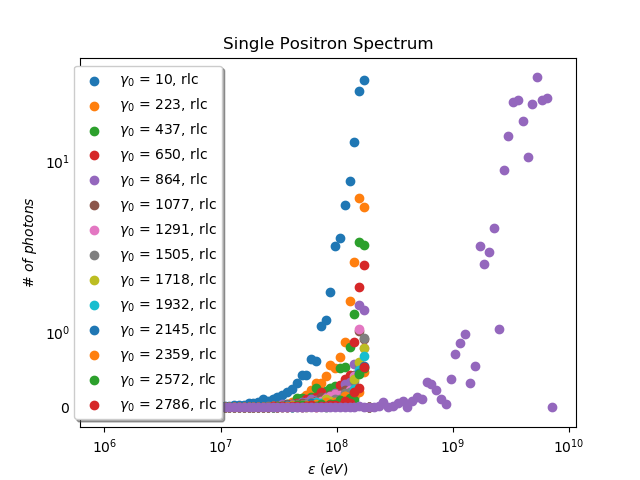

In [14]:

fig4, ax4 = plt.subplots()
for i in range(len(gamma0)-1):
    ax4.scatter(en_rlc, ph_en_rlc[i], label = '$\gamma_0$ = {}, rlc'.format(int(gamma0[i])))
#     ax4.scatter(en, ph_en[i], label = '$\gamma_0$ = {}'.format(int(gamma0[i])))
    ax4.set(xlabel = '$ \epsilon \ (eV)$', ylabel = '$\# \ of \ photons$', title = 'Single Positron Spectrum')
    ax4.set_xscale(value = 'symlog', nonposx = 'clip')
    ax4.set_yscale(value = 'symlog', nonposy = 'clip')
    ax4.legend(loc='center right', ncol=1, fancybox=True, shadow=True, bbox_to_anchor=(0.3, 0.5))
#     fig4.savefig('test_spectrum')
ax4.scatter(en, ph_en[i], label = '$\gamma_0$ = {}'.format(int(gamma0[i])))
plt.show()